# Salifor Motors员工留存率分析


项目背景：
Salifort Motors是一家虚构的能源汽车制造商，其全球员工超过100000名。该公司的人力资源部门想采取一些措施提高员工的留存率，相比起寻找和雇佣新员工的成本和风险，
尽可能保存现有运营结构杯认为是更合理的方式。

因此本项目收集了14999名员工信息作为样本，将进行数据分析的全部过程并提供数据驱动的建议。由于本项目关注提高员工的留存率，因此需要挖掘员工离职的相关因素，并构建合适
的模型预测员工离职的可能性。


数据指标简介：

satisfaction_level：员工报告的工作满意度

last_evaluation： 员工当前最后一次记录的绩效考核得分

number_project： 员工参与的项目总数

average_monthly_hours： 员工每月平均工作时长

time_spend_company： 员工在公司工作的年份

Work_accident： 是否在公司发生事故

left： 是否离职

promotion_last_5years： 员工在过去5年是否得到晋升

Department： 所在部门

salary： 工资


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve

import pickle

In [2]:
pd.set_option('display.max_columns', None) 

d1 = pd.read_csv("HR_capstone_dataset.csv")

d1.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## 1. 数据处理

In [3]:
d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
d1.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [5]:
d1.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [3]:
d1 = d1.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})

d1.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [7]:
d1.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [8]:
d1.duplicated().sum()

3008

In [9]:
d1[d1.duplicated()].head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
396,0.46,0.57,2,139,3,0,1,0,sales,low
866,0.41,0.46,2,128,3,0,1,0,accounting,low
1317,0.37,0.51,2,127,3,0,1,0,sales,medium
1368,0.41,0.52,2,132,3,0,1,0,RandD,low
1461,0.42,0.53,2,142,3,0,1,0,sales,low


In [4]:
d2 = d1.drop_duplicates(keep='first')
d2.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


清洗脏数据，统一列名格式，检查异常值，数据格式，删除重复值等

## 2.数据探索

开始可视化和检查各变量之间的关系

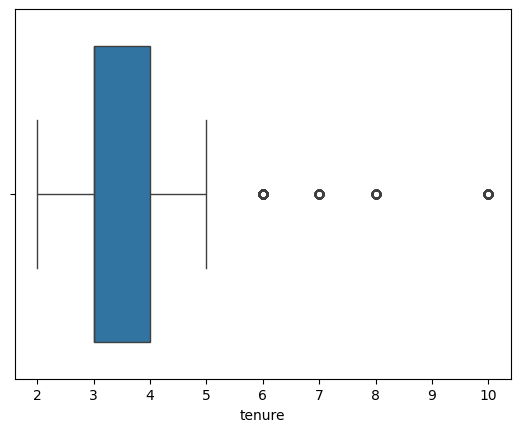

In [5]:
sns.boxplot(x=d2['tenure'])
plt.show()

检查员工工作年限的整体情况，如图所示中位数集中在3-4区间，并存在异常值。

In [6]:
per25 = d1['tenure'].quantile(0.25)
per75 = d1['tenure'].quantile(0.75)
iqr = per75 - per25

ul = per75 + 1.5*iqr
ll = per25 - 1.5*iqr

print('upper limit:', ul)
print('lower limit:', ll)

outl = d2[(d2['tenure']>ul) | (d2['tenure']<ll)]
print('outliers:', len(outl))

upper limit: 5.5
lower limit: 1.5
outliers: 824


计算工作年限分布的上下限与离群值数量。

In [7]:
print(d2['left'].value_counts())
print()
print(d2['left'].value_counts(normalize=True))

left
0    10000
1     1991
Name: count, dtype: int64

left
0    0.833959
1    0.166041
Name: proportion, dtype: float64


计算在职和离职员工的分布情况，83.4%的员工在职

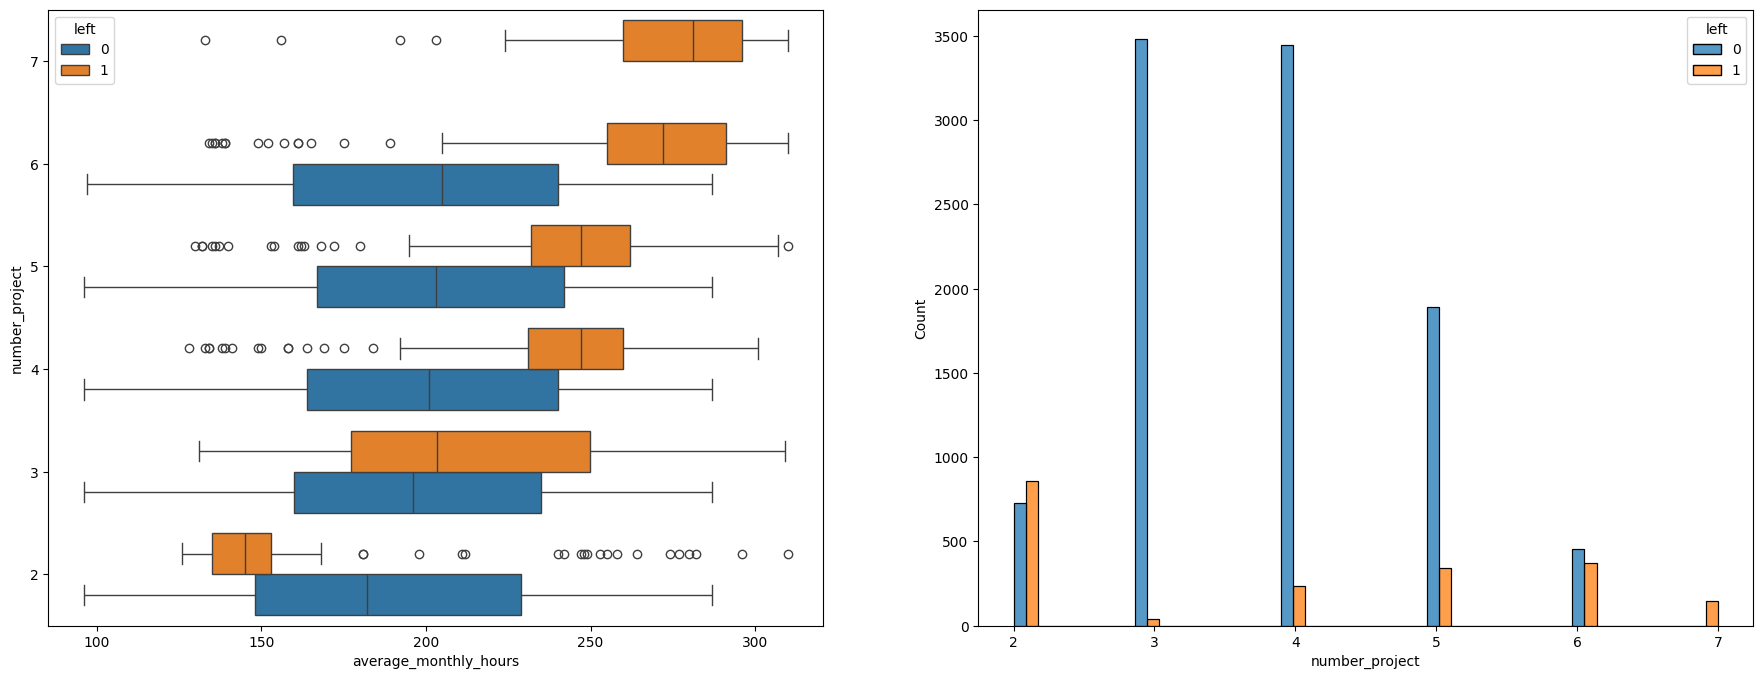

In [10]:
fig, ax = plt.subplots(1,2,figsize=(22, 8))

sns.boxplot(d2, x='average_monthly_hours', y='number_project',hue='left', orient='h',ax=ax[0])
ax[0].invert_yaxis()

sns.histplot(d2, x='number_project', hue='left', multiple='dodge',ax=ax[1])

plt.show()

左图显示项目完成更多的员工平均工作时间也更长，符合自然情况。

然而右图的信息显示离职员工集群分别集中在低项目完成数低工时，与高项目完成数高工时中。

根据此趋势可以初步推断低工时群体很可能是业绩不足被解雇，而高工时则是过度工作不堪重负辞职。

此外，完成项目在3-4的区间中员工离职率最低，可以作为员工项目完成参考的最佳标准。

In [11]:
d2[d2['number_project']==7]['left'].value_counts()

left
1    145
Name: count, dtype: int64

In [12]:
amh = (50*40)/12
amh

166.66666666666666

以8小时工作制，每年工作50周为标准计算出每年平均工时标准为166.67小时。

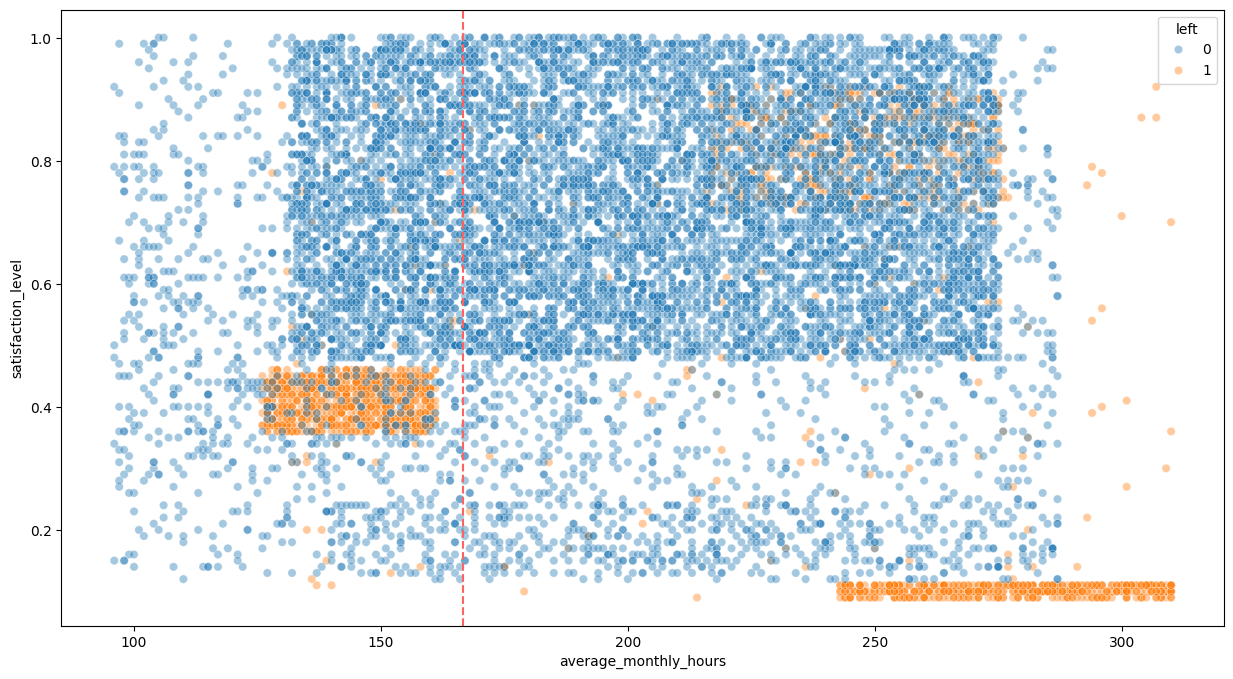

In [13]:
plt.figure(figsize=(15, 8))

sns.scatterplot(data=d2, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 h./m.', ls='--')

plt.show()

上图显示离职人主要集中在三个区域，其中低满意度高工时的群体最低工时都接近250小时，远远超出了平均工时标准，显然这部分员工不堪重负同时也可以想象他们获得的待遇与付出可能并不匹配。

中满意度低工时群体显然属于被解雇人群。

而高满意度高工时群体存在点合成的可能性，并不清晰，暂时无法轻易下推断。

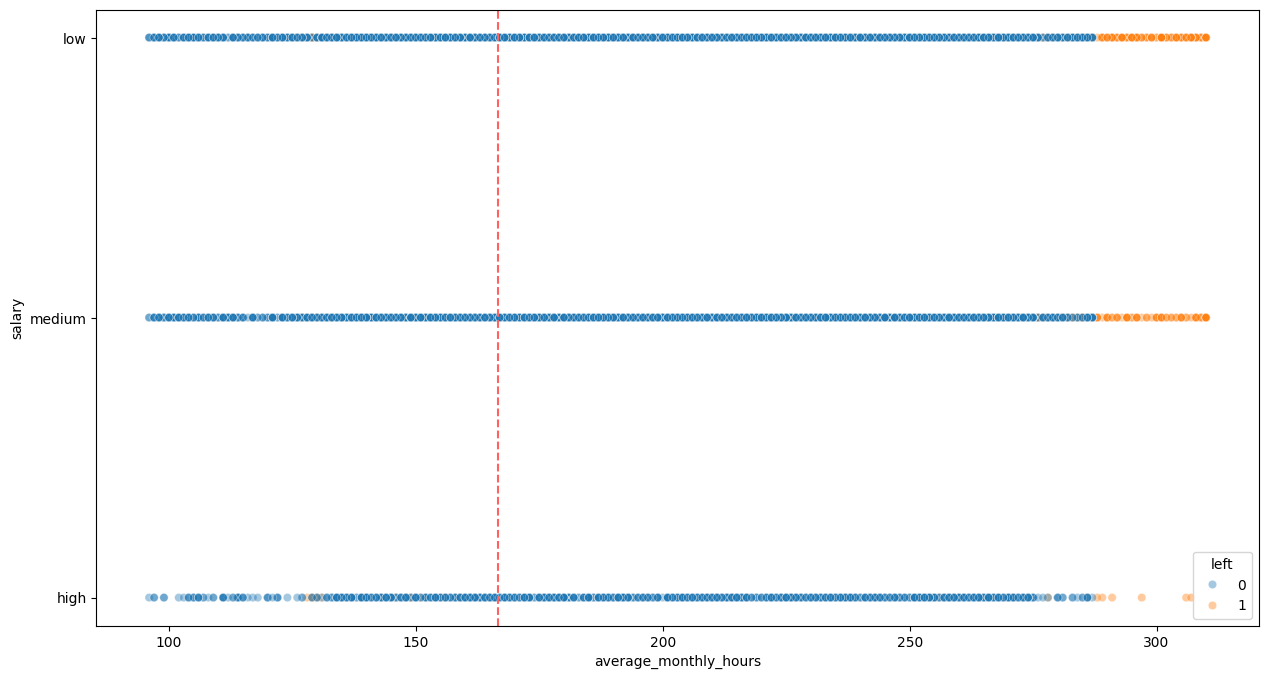

In [14]:
plt.figure(figsize=(15, 8))

sns.scatterplot(data=d2, x='average_monthly_hours', y='salary', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 h./m.', ls='--')

plt.show()

可见离职人群体集中在中低工资却高工时的区域中，印证了上图离职高工时员工没有获得应得待遇的推论。

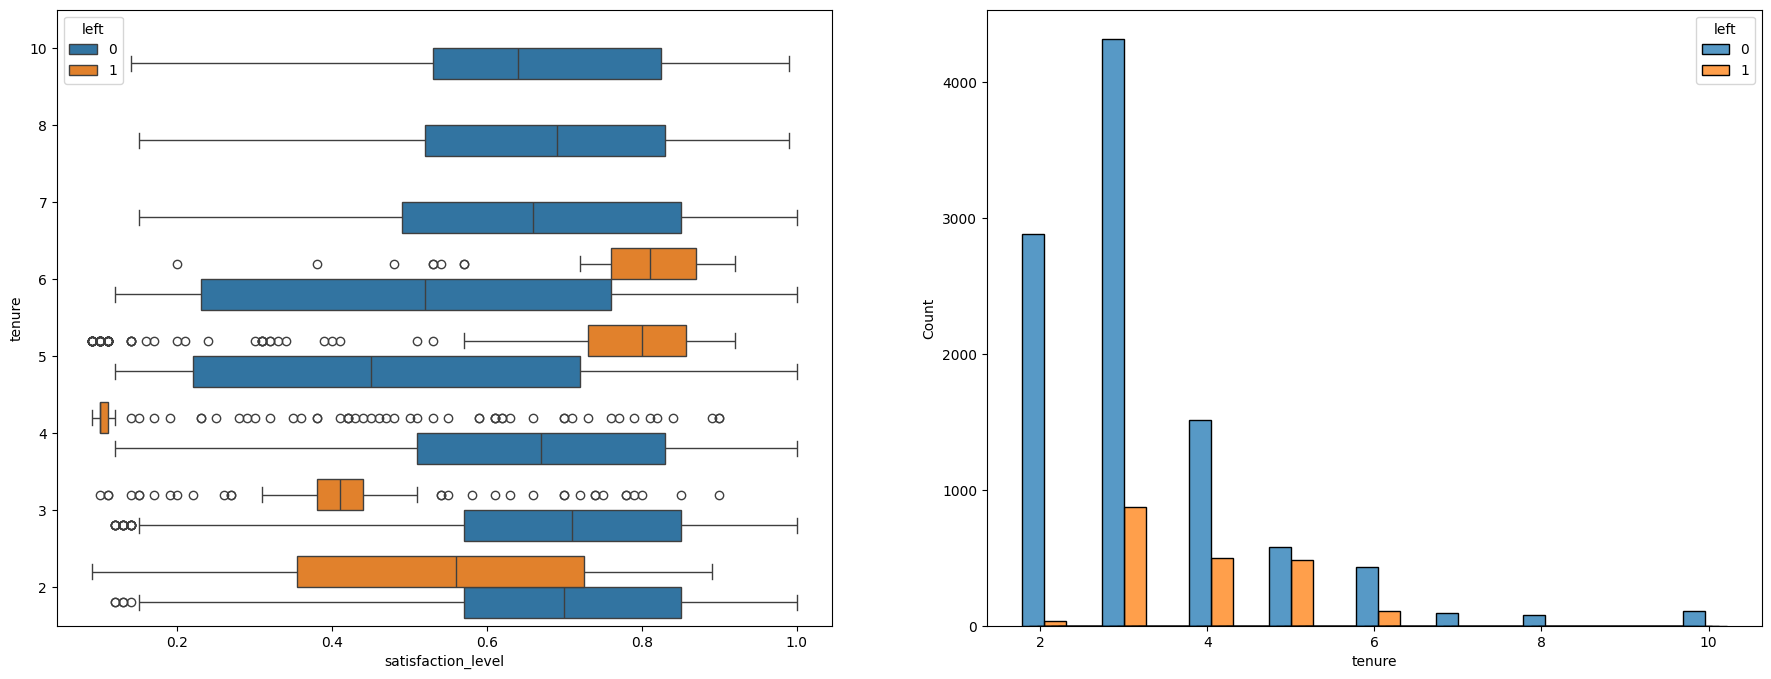

In [15]:
fig, ax = plt.subplots(1,2,figsize=(22,8))

sns.boxplot(d2, x='satisfaction_level', y='tenure',hue='left', orient='h',ax=ax[0])
ax[0].invert_yaxis()

sns.histplot(d2, x='tenure', hue='left', multiple='dodge',shrink=6,ax=ax[1])

plt.show()


该阶段将离职人划分为低工龄中低满意度和中等工龄较高满意度。

低工龄群体结合前文显然与被辞退群体重合，而中等工龄群体缺乏更具体信息难以判断属性，可初步推断为在公司内得到成长的跳槽高业绩员工。

此外，4年工龄离职的群体评价尤为低下，可以挖掘该年份的公司政策是否发生改变。

In [16]:
d2.groupby(['left'])['satisfaction_level'].agg([np.mean, np.median])

C:\Users\wczax\AppData\Local\Temp\ipykernel_12556\2945517374.py:1: FutureWarning: The provided callable <function mean at 0x000002815DDF4D60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  d2.groupby(['left'])['satisfaction_level'].agg([np.mean, np.median])
C:\Users\wczax\AppData\Local\Temp\ipykernel_12556\2945517374.py:1: FutureWarning: The provided callable <function median at 0x000002815DF1BF60> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  d2.groupby(['left'])['satisfaction_level'].agg([np.mean, np.median])


,mean,median
left,,
0,0.667365,0.69
1,0.440271,0.41


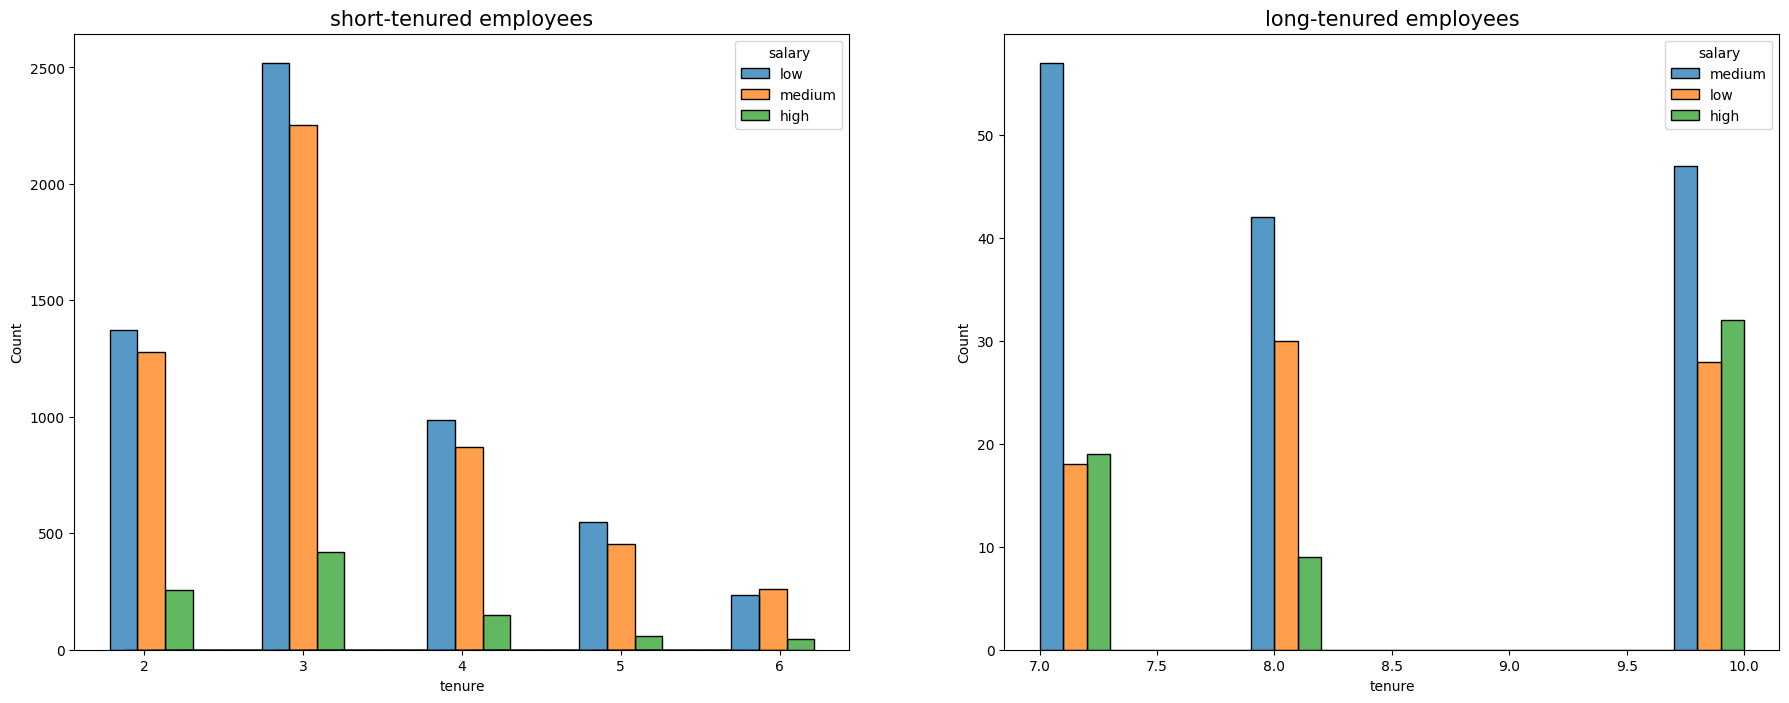

In [17]:
fig, ax = plt.subplots(1,2,figsize=(22,8))

tenure1 = d2[d2['tenure']<7]
tenure2 = d2[d2['tenure']>6]

sns.histplot(tenure1, x='tenure', hue='salary', multiple='dodge',shrink=6,ax=ax[0])
ax[0].set_title('short-tenured employees', fontsize=15)
sns.histplot(tenure2, x='tenure', hue='salary', multiple='dodge',shrink=1,ax=ax[1])
ax[1].set_title('long-tenured employees', fontsize=15)

plt.show()

上图可得知低工龄员工以中低薪为主，这符合一般市场情况，但长期任职的员工中高薪也占比较低，可以推断为管理层岗位。

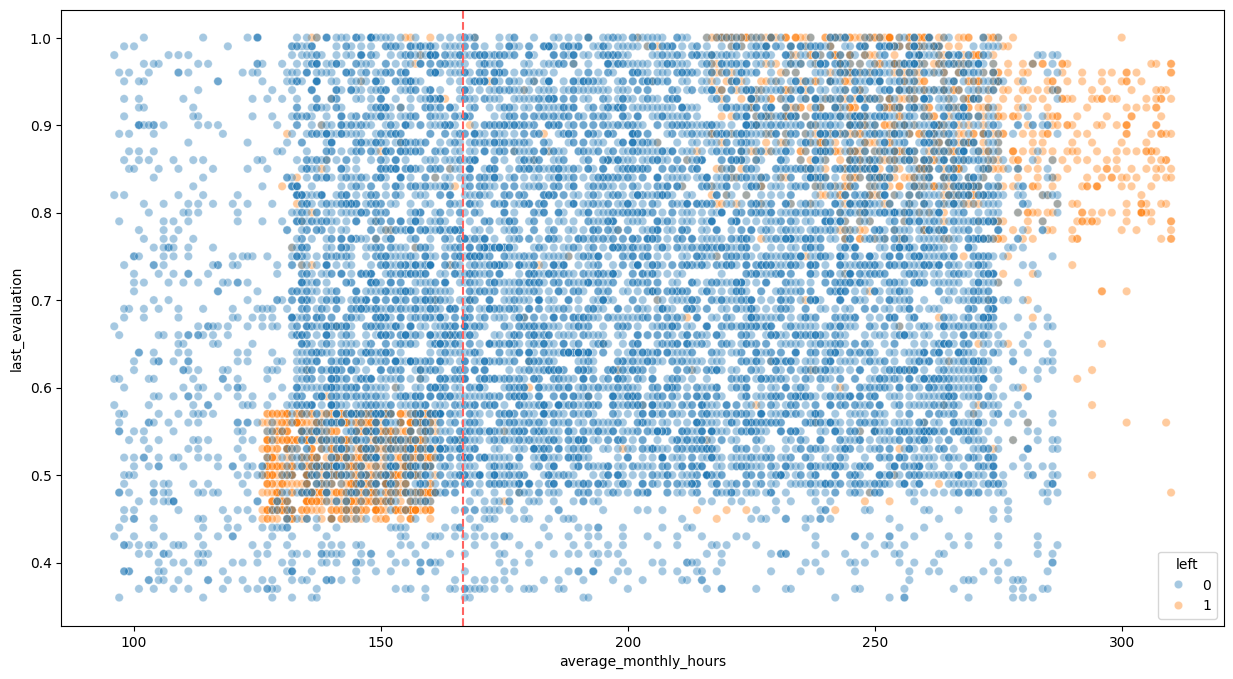

In [18]:
plt.figure(figsize=(15, 8))

sns.scatterplot(data=d2, x='average_monthly_hours', y='last_evaluation', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 h./m.', ls='--')

plt.show()

该图显著划分了两组离职员工，低评价低工时被解雇者，与高评价高工时辞职者，与前文各指标分析情况相符。

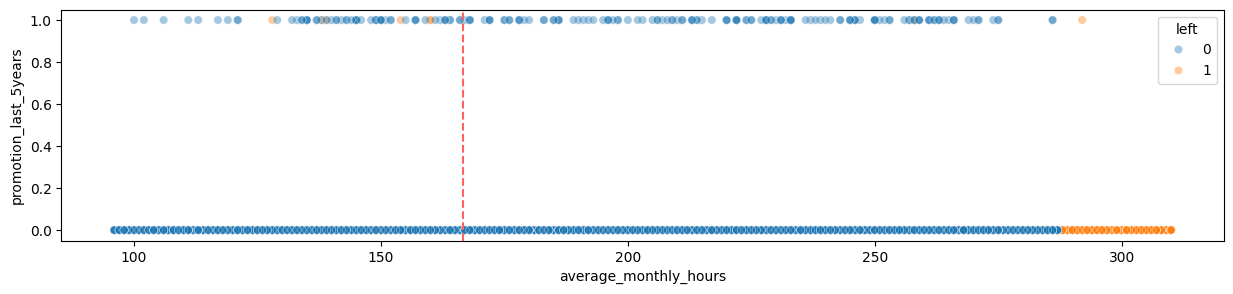

In [19]:
plt.figure(figsize=(15, 3))

sns.scatterplot(data=d2, x='average_monthly_hours', y='promotion_last_5years', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='#ff6361', label='166.67 h./m.', ls='--')

plt.show()

很显然，离职者在过去5年里绝大多数都未能获得晋升，而他们同时也是工时最长的员工，结合前文高工时往往完成了高项目数和业绩的情况，公司的晋升机制可能存在相当大的问题，最出色的员工都没能留下。

相反，成功得到晋升的员工离职的比例很低，这似乎揭示了一种激励方式。

In [20]:
d2['department'].value_counts()

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64

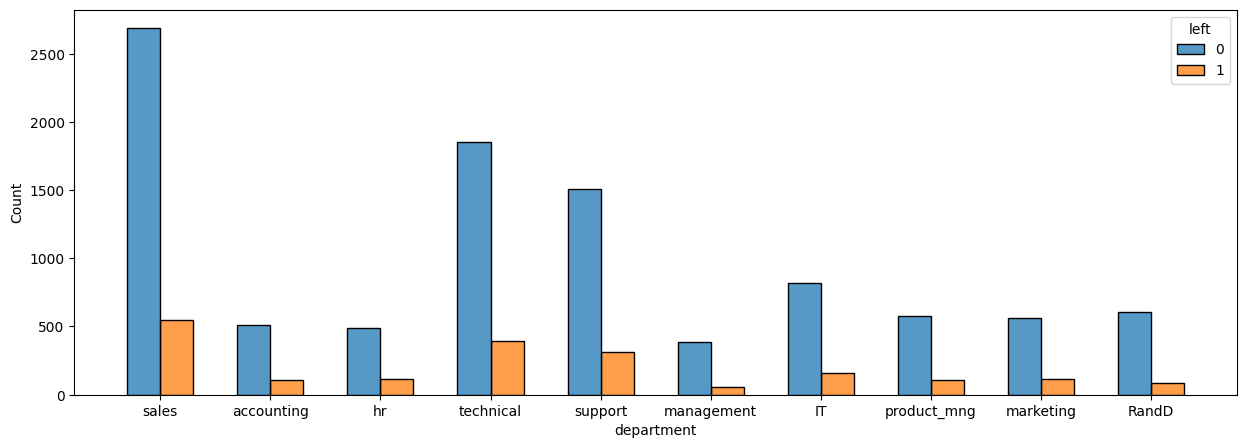

In [21]:
plt.figure(figsize=(15, 5))

sns.histplot(data=d2, x='department', hue='left', multiple='dodge', shrink=0.6)

plt.show()

各部门之间的留存率并没有什么显著差异，该指标和预测变量间可能不会有太大影响。

In [22]:
d3 = d2.copy()
d3['salary'] = d3['salary'].astype('category').cat.set_categories(['low', 'medium', 'high']).cat.codes
d4 = d3.drop('department', axis=1)

d3 = pd.get_dummies(d3, drop_first=True, columns=['department'])
d4 = pd.get_dummies(d4, drop_first=True)
d3.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,True,False,False


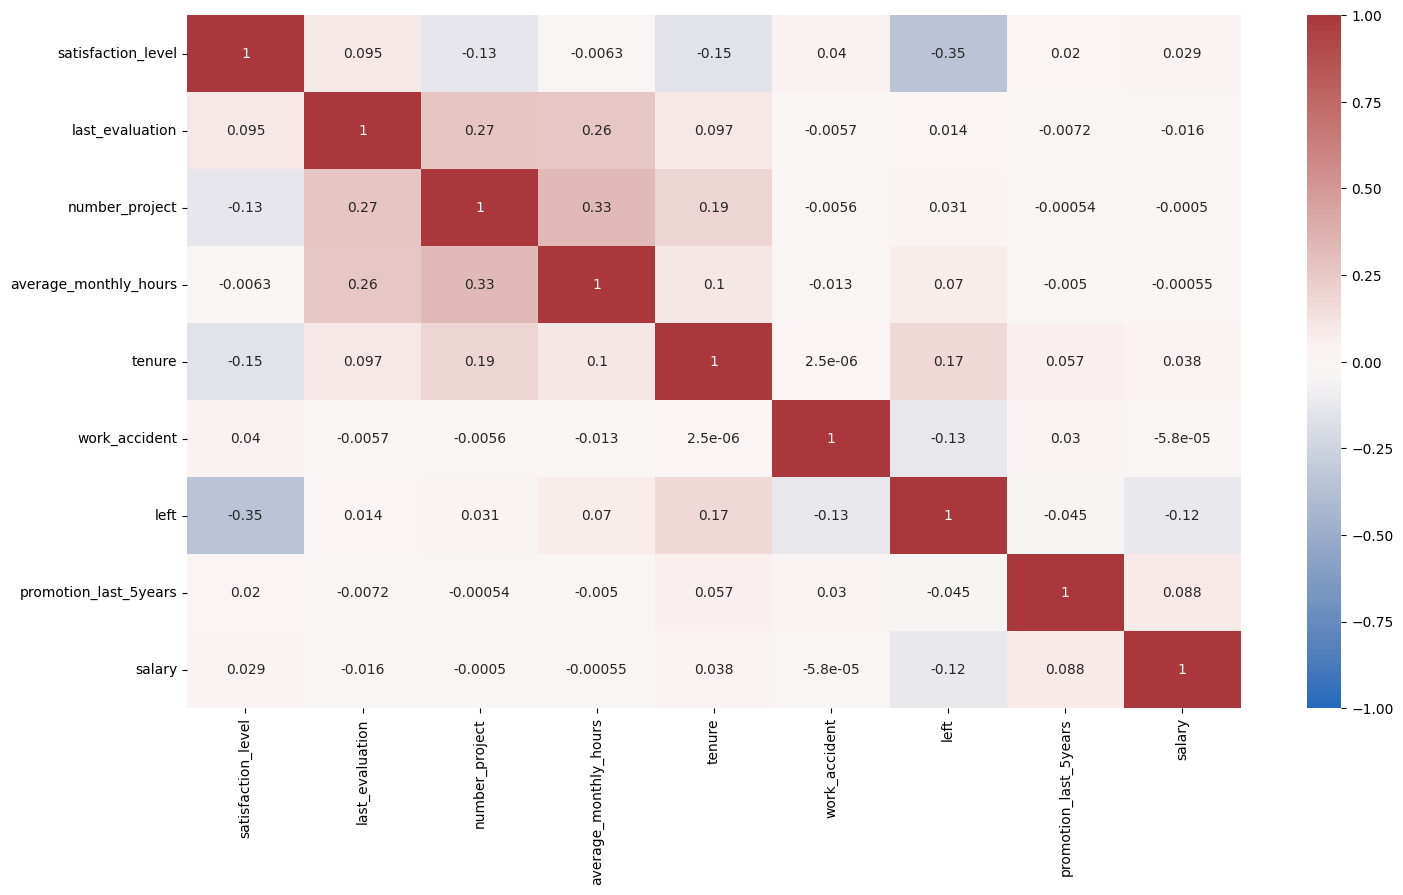

In [23]:
plt.figure(figsize=(17, 9))
heatmap = sns.heatmap(d4.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
plt.show()

根据主要变量完成热力图观察变量间的相关性，其中项目评分，完成项目数和月平均工时之间存在较明显关联

## 3.数据建模

由于预测员工的留存与否为二元划分问题，因此本项目采用随机森林模型兼顾效率和效果进行预测。


采用所有变量进行第一次建模预测。

### 3.1 构建决策树

In [30]:
d3.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,True,False,False


In [31]:
d5 = d3[(d3['tenure']>=ll) & (d3['tenure']<=ul)]
d5.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,True,False,False


In [32]:
y = d5['left']
x = d5.drop('left', axis=1)

y.head()

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=0)

In [34]:
tree = DecisionTreeClassifier(random_state=0)
tree_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
tree1 = GridSearchCV(tree, tree_params, scoring=scoring, cv=4, refit='roc_auc')


In [35]:
%%time
tree1.fit(x_train, y_train)

CPU times: total: 1.81 s
Wall time: 3.72 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [36]:
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [37]:
tree1.best_score_

0.9741265306913758

In [38]:
def make_results(model_name, model_object, metric):
        metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }
        cv_results = pd.DataFrame(model_object.cv_results_)
        best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]
        auc = best_estimator_results.mean_test_roc_auc
        f1 = best_estimator_results.mean_test_f1
        recall = best_estimator_results.mean_test_recall
        precision = best_estimator_results.mean_test_precision
        accuracy = best_estimator_results.mean_test_accuracy
        table = pd.DataFrame()
        table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
        return table

In [39]:
tree_results = make_results('dt cv', tree1, 'auc')
tree_results

,model,precision,recall,F1,accuracy,auc
0,dt cv,0.95541,0.912133,0.933245,0.97803,0.974127


### 3.2 构建随机森林

In [ ]:
rf = RandomForestClassifier(random_state=0)
rfcv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
rf1 = GridSearchCV(rf, rfcv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
%%time
rf1.fit(x_train, y_train)

In [26]:
path = '/Users/wczax/Desktop/1/exe'

In [ ]:
with open(path + 'rf1_model.pickle', 'wb') as to_write:
    pickle.dump(rf1, to_write)


In [27]:
with open(path + 'rf1_model.pickle', 'rb') as to_read:
    rf1=pickle.load(to_read)

In [28]:
rf1.best_score_

0.9817936779007908

In [29]:
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 300}

In [40]:
rf1_cv_results = make_results('rf cv', rf1, 'auc')
print(tree_results)
print(rf1_cv_results)

   model  precision    recall        F1  accuracy       auc
0  dt cv    0.95541  0.912133  0.933245   0.97803  0.974127
   model  precision    recall        F1  accuracy       auc
0  rf cv   0.970663  0.915678  0.942318  0.981135  0.981794


In [41]:
def scores(model_name, model, X_test_data, y_test_data):
    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]})
  
    return table

In [42]:
rf1_test = scores('rf1 test', rf1, x_test, y_test)
rf1_test

,model,precision,recall,f1,accuracy,AUC
0,rf1 test,0.967033,0.934183,0.950324,0.983524,0.96386


### 3.3 修改变量，进行第二次模型拟合

In [43]:
d6 = d5.drop('satisfaction_level', axis=1)
d6.head()

,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,True,False,False
2,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,True,False,False
3,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,True,False,False
4,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,True,False,False
5,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,True,False,False


166.67为每月平均工作时间，将170小时设定为临界点，超出170小时的员工为过度工作。

In [44]:
d6['overworked'] = d6['average_monthly_hours']
d6['overworked'] = (d6['overworked']>170).astype(int)
d6['overworked'].head()

0    0
2    1
3    1
4    0
5    0
Name: overworked, dtype: int32

In [45]:
d6 = d6.drop('average_monthly_hours', axis=1)
d6.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,False,False,False,False,False,False,True,False,False,0
2,0.88,7,4,0,1,0,1,False,False,False,False,False,False,True,False,False,1
3,0.87,5,5,0,1,0,0,False,False,False,False,False,False,True,False,False,1
4,0.52,2,3,0,1,0,0,False,False,False,False,False,False,True,False,False,0
5,0.50,2,3,0,1,0,0,False,False,False,False,False,False,True,False,False,0


In [46]:
y = d6['left']
x = d6.drop('left', axis=1)

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y, random_state=0)

In [48]:
tree = DecisionTreeClassifier(random_state=0)
tree_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
tree2 = GridSearchCV(tree, tree_params, scoring=scoring, cv=4, refit='roc_auc')


In [49]:
%%time
tree2.fit(x_train, y_train)

CPU times: total: 1.36 s
Wall time: 3.36 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [50]:
tree2.best_params_

{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [51]:
tree2.best_score_

0.9627115404211541

可以看到即便失去了两个变量模型的得分依然很出色，没有出现较大的波动。

In [52]:
tree2_results = make_results('dt2 cv', tree2, 'auc')
tree2_results

,model,precision,recall,F1,accuracy,auc
0,dt2 cv,0.853969,0.905047,0.878602,0.957851,0.962712


部分分数因为变量的缺失出现了下滑。

In [54]:
rf = RandomForestClassifier(random_state=0)
rfcv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
rf2 = GridSearchCV(rf, rfcv_params, scoring=scoring, cv=4, refit='roc_auc')

In [55]:
%%time
rf2.fit(x_train, y_train)

CPU times: total: 7min 48s
Wall time: 15min 21s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [56]:
with open(path + 'rf2_model.pickle', 'wb') as to_write:
    pickle.dump(rf2, to_write)


In [57]:
with open(path + 'rf2_model.pickle', 'rb') as to_read:
    rf2=pickle.load(to_read)

In [58]:
rf2.best_score_

0.9699356312597972

In [59]:
rf2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [60]:
rf2_cv_results = make_results('rf2 cv', rf2, 'auc')
print(tree2_results)
print(rf2_cv_results)

    model  precision    recall        F1  accuracy       auc
0  dt2 cv   0.853969  0.905047  0.878602  0.957851  0.962712
    model  precision    recall        F1  accuracy       auc
0  rf2 cv   0.891836  0.898673  0.895084  0.964538  0.969936


模型结果显示整体分数出现下降，但作为决定性指标的auc没有出现明显波动，依然表现出色。

In [61]:
rf2_test = scores('rf2 test', rf2, x_test, y_test)
rf2_test

,model,precision,recall,f1,accuracy,AUC
0,rf2 test,0.896266,0.917197,0.906611,0.968123,0.947828


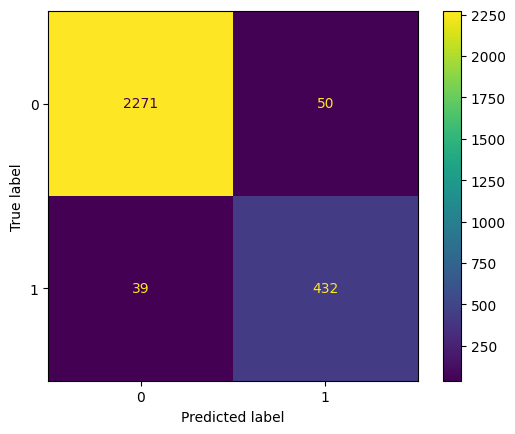

In [62]:
rf2_p = rf2.best_estimator_.predict(x_test)
cm = confusion_matrix(y_test, rf2_p, labels = rf2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf2.classes_)
disp.plot()
plt.show()

True positive: 预测留下且实际留下
False positive：预测留下却实际离开
False negative：预测离开却实际留下
True negative: 预测离开且实际离开

TN多于FP，即有一些员工存在被解雇的风险

### 3.4 探索模型中的最重要特征

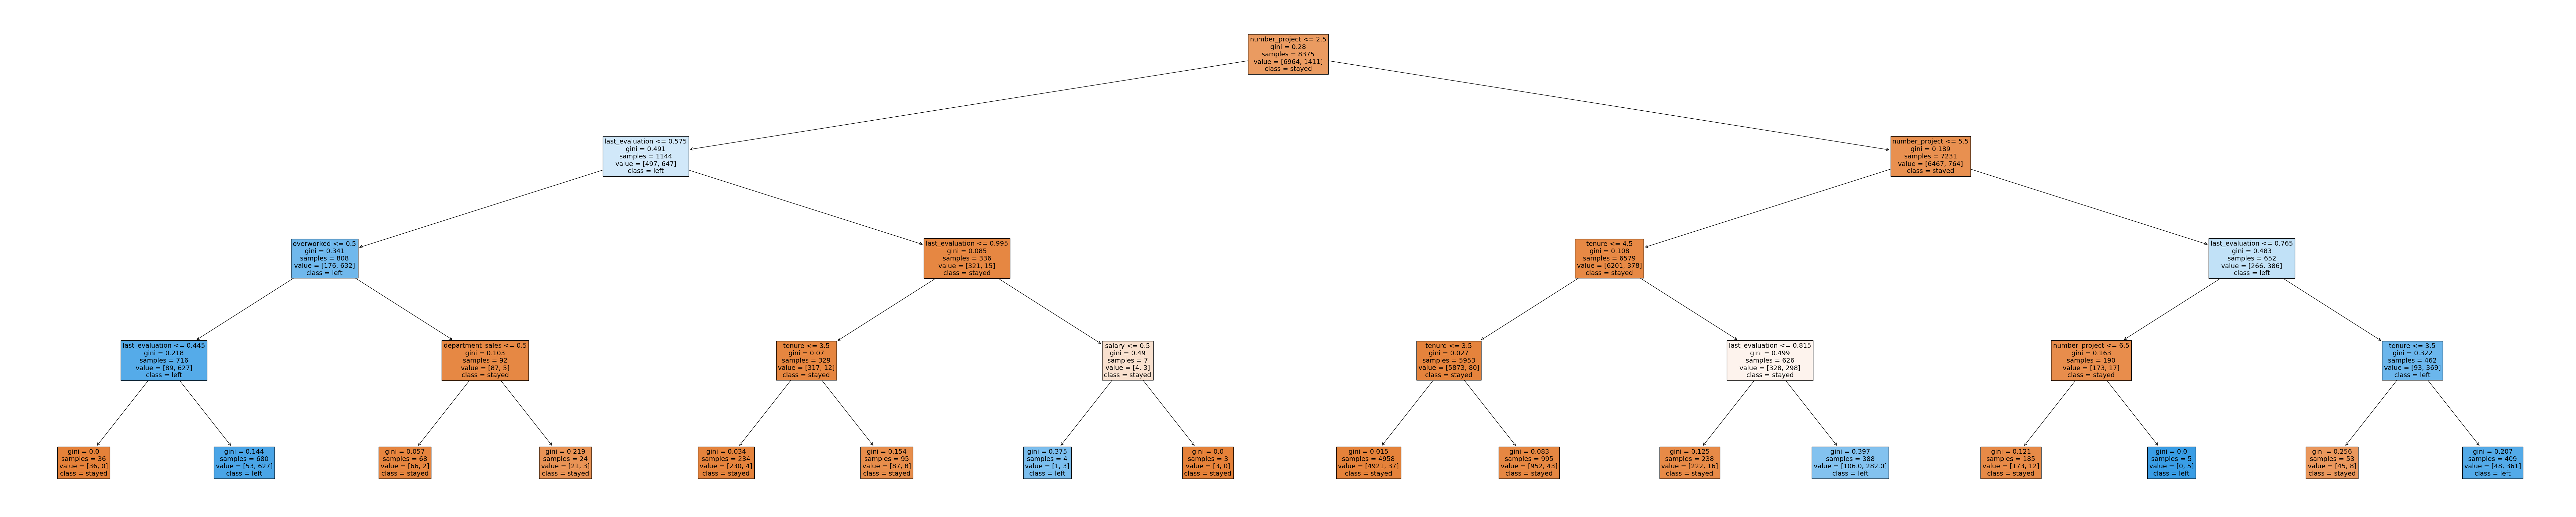

In [63]:
plt.figure(figsize=(100,20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=x.columns, class_names={0:'stayed', 1:'left'}, filled=True)
plt.show()

注：可以双击点开决策树查看细节。

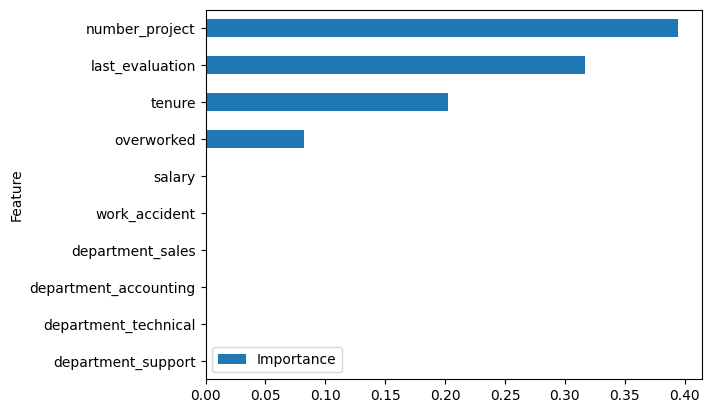

In [64]:
feat_impt = rf2.best_estimator_.feature_importances_
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]
feat = x.columns[ind]
feat_impt = feat_impt[ind]
y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")

y_sort_df.plot(kind='barh',x="Feature",y="Importance")

plt.show()

图表显示在此随机森林模型中number_project, last_avaluation, tenure, overworked重要性依次最高。它们对预测结果变量最有帮助，而其他的特征造成的影响微乎其微。

## 4. 总结

In [ ]:
可视化分析与模型证明了该公司整体存在员工过度工作的问题，为了提高留存率，本项目研究建议公司可从开源和节流两个方向入手：

节流

1. 控制员工的项目完成数，调整业绩指标，完成4个项目即可获得公司当月度奖金上限，使公司的工时与工资分配更加平均化，减小员工间的不平衡；


2. 设立加班时间上限，超过上限的工时减少加班工资，降低员工加班的积极性同时节省开支；

开源

1. 月度记录员工的工时和业绩情况，使员工的贡献可视化与透明化，并且为最高贡献的员工提供合理的晋升机会；

2. 重新设计奖金与薪酬制度，为高贡献员工提供更合理的薪资结构；

3. 进一步探索工龄为4年的员工离职原因，这一时间作为新老员工的评价分界点很大概率产生了重大政策变故；